# Assignment 2: My Spatial Databases
### Important Time
Submission: 23:59 Mar. 21, 2024 (UTC+8)
### Related Datasets
Assignment2-2012_BIT_POI.csv
### Task Description
1. Build an in-memory spatial database for Point of Interest (POI) that can support the spatial
range query and the nearest neighbor query.
2. Demonstrate the efficiency of the spatial index.
3. Use your database to answer following questions.
a) What's the nearest ATM (type_code starting with "1603XX") around Central Building
of BIT (latitude:39.958, longitude:116.311)?
b) How many restaurants (type_code starting with "5XXXX") within 500 meters of the
south door of BIT (latitude:39.955, longitute:116.310)?
### What You Need to Program
1. An index-building function (implemented by your own)
index = IndexBuilding(file_path)
2. A range query function based on the spatial index
res = RangeQuery(query_range, type_regex_str, index)
"query_range" could either be
- (upper-left, bottom-right) rectangle
- A central point + a radius square
"regex_str" is the regular expression string to match the type_code
3. A nearest neighbor query function based on the spatial index
res = NNQuery(query_point, type_regex_str, index)
4. A brute-force range query function
res=RangeScan(query_range, type_regex_str, file_path)
5. A brute-force nearest neighbor query function
res=NNScan(query_point, type_regex_str, file_path)
6. Compare the efficiency of different queries with/without the spatial index
7. Answer above questions

In [2046]:
import csv
import math
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians

import osmnx as ox # Library for open street maps

## Class for the point of interest (e.g. - atm, restaurant)

In [2047]:
class POI:
    def __init__(self, id, name, latitude, longitude, type_code, category):
        self.id = id
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.type_code = type_code
        self.category = category

Converting distance between two points into meters

In [2048]:
def degrees_to_meters(lat1, lon1, lat2, lon2):
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Distance between two points in meters
    distance = R * c * 1000
    return distance

## Main class for index building
This class implements different methods: brute force and spatial indexing

In [2049]:
class IndexBuilding:
    def __init__(self, file_path):
        self.poi_list = []
        self.poi_matrix = []
        
        self.diff_latitude = 0
        self.diff_longitude = 0
        
        self.step_latitude = 0
        self.step_longitude = 0
        
        self.min_latitude = 0
        self.min_longitude = 0
        
        self.max_latitude = 0
        self.max_longitude = 0
        
        self.boarders = 10
             
        self.build_index_brute_force(file_path)
        self.build_spatial_index()
        
    # An index-building function (for brute force)
    def build_index_brute_force(self, file_path):
        with open(file_path, 'r', encoding='utf-8-sig') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header row
            id = -1
            for row in reader:
                id += 1
                name = row[0]
                latitude = float(row[1])
                longitude = float(row[2])
                type_code = row[3]
                category = row[4]
                poi = POI(id, name, latitude, longitude, type_code, category)
                self.poi_list.append(poi)
    
    # An index-building function (for spatial)
    def build_spatial_index(self):
        max_latitude = max(poi.latitude for poi in self.poi_list)
        max_longitude = max(poi.longitude for poi in self.poi_list)
        min_latitude = min(poi.latitude for poi in self.poi_list)
        min_longitude = min(poi.longitude for poi in self.poi_list)
        
        diff_latitude = max_latitude - min_latitude
        diff_longitude = max_longitude - min_longitude
        
        step_latitude = diff_latitude / self.boarders
        step_longitude = diff_longitude / self.boarders
        
        poi_matrix = [[[] for _ in range(self.boarders + 1)] for _ in range(self.boarders + 1)]
    
        for poi in self.poi_list:
            # Adding poi in the cell
            i = int((poi.longitude - min_longitude) // step_longitude)
            j = int((poi.latitude - min_latitude) // step_latitude)
            poi_matrix[i][j].append(poi) 
            
        self.poi_matrix = poi_matrix
        
        self.step_latitude = step_latitude
        self.step_longitude = step_longitude
        
        self.min_latitude = min_latitude
        self.min_longitude = min_longitude
        
        self.max_latitude = max_latitude
        self.max_longitude = max_longitude
        
        self.diff_latitude = diff_latitude
        self.diff_longitude = diff_longitude
        
    # A brute-force range query function
    def range_scan(self, query_range, type_regex_str):
        result = []
        for poi in self.poi_list:
            if query_range.contains(poi.latitude, poi.longitude) and poi.type_code.startswith(type_regex_str):
                result.append(poi)
        return result
    
    # A brute-force nearest neighbor query function
    def nearest_neighbor_scan(self, query_point, type_regex_str):
        result = None
        min_distance = 9999 # meters 
        for poi in self.poi_list:
            if poi.type_code.startswith(type_regex_str):
                distance = degrees_to_meters(query_point.latitude, query_point.longitude, poi.latitude, poi.longitude)
                if distance < min_distance:
                    min_distance = distance
                    result = poi
        return result
    
    # A nearest neighbor query function based on the spatial index
    def nearest_neighbor_query(self, query_point, type_regex_str):
        
        # Index of query point in our matrix (spatial indexing)
        i = int((query_point.longitude - self.min_longitude) // self.step_longitude) - 1
        j = int((query_point.latitude - self.min_latitude) // self.step_latitude) - 1
        
        # Calculating the coordinates of the sides of the box (cell) where query point is located
        down = self.min_longitude + i * self.step_longitude # starting point of the down cell
        up = down + self.step_longitude # ending point of the down cell
        left = self.min_latitude + j * self.step_latitude
        right = left + self.step_latitude
        
        # Calculating the distances from query point to the boarders of the cell
        # To check do we need to check adjacent cells
        distance_to_left = degrees_to_meters(query_point.latitude, query_point.longitude, left, query_point.longitude)
        distance_to_right = degrees_to_meters(query_point.latitude, query_point.longitude, right, query_point.longitude)
        distance_to_up = degrees_to_meters(query_point.latitude, query_point.longitude, query_point.latitude, up)
        distance_to_down = degrees_to_meters(query_point.latitude, query_point.longitude, query_point.latitude, down)
        
        result = None
        min_distance = 9999 # meters
        # Checking points in squares
        # Checking near cells in case of some point in another cell point is closer
        for di in [0, -1, 1]:
            for dj in [0, -1, 1]:
                new_i = i + di
                new_j = j + dj
                if 0 <= new_i < len(self.poi_matrix) and 0 <= new_j < len(self.poi_matrix[0]):
                    '''
                    Example
                    Q - query point (0, 0)
                    Checking 11 if upper side and right side are closer than the nearest point
                    #### #### ####
                    #  # #10# #11#
                    #### #### ####
                    
                    #### #### ####
                    #  # #Q # #  #
                    #### #### ####
                    
                    #### #### ####
                    #  # #  # #  #
                    #### #### ####
                    '''
                    if (((di, dj) == (0, 1) and min_distance < distance_to_right or
                            (di, dj) == (0, -1) and min_distance < distance_to_left or
                            (di, dj) == (-1, 0) and min_distance < distance_to_down or
                            (di, dj) == (1, 0) and min_distance < distance_to_up or
                            (di, dj) == (-1, -1) and min_distance < distance_to_down and min_distance < distance_to_left or
                            (di, dj) == (1, -1) and min_distance < distance_to_left and min_distance < distance_to_up or
                            (di, dj) == (1, 1) and min_distance < distance_to_up and min_distance < distance_to_right or
                            (di, dj) == (-1, 1) and min_distance < distance_to_right and min_distance < distance_to_down) or
                            (di, dj) == (0, 0)):
                        for poi in self.poi_matrix[new_i][new_j]:        
                            if poi.type_code.startswith(type_regex_str):
                                distance = degrees_to_meters(query_point.latitude, query_point.longitude, poi.latitude, poi.longitude)
                                if distance < min_distance:
                                    min_distance = distance
                                    result = poi
                    
        # Returning if query point is too close to the box side
        return result
    
    # A range query function based on the spatial index
    def range_query(self, query_range, type_regex_str):
        
        # Checking cells that included in requesting rectangle 
        max_longitude = query_range.upper_left.longitude
        if max_longitude > self.max_longitude: max_longitude = self.max_longitude
            
        min_longitude = query_range.bottom_right.longitude
        if min_longitude < self.min_longitude: min_longitude = self.min_longitude
        
        max_latitude = query_range.bottom_right.latitude
        if max_latitude > self.max_latitude: max_latitude = self.max_latitude
        
        min_latitude = query_range.upper_left.latitude
        if min_latitude < self.min_latitude: min_latitude = self.min_latitude
        
        # Borders for the searching
        min_j = int((min_latitude - self.min_latitude) // self.step_latitude)
        max_j = int((max_latitude - self.min_latitude) // self.step_latitude)
        
        min_i = int((min_longitude - self.min_longitude) // self.step_longitude)
        max_i = int((max_longitude - self.min_longitude) // self.step_longitude)
        
        result = []
        for i in range(min_i, max_i + 1):
            for j in range(min_j, max_j + 1):
                for poi in self.poi_matrix[i][j]:
                    if (query_range.contains(poi.latitude, poi.longitude) 
                            and poi.type_code.startswith(type_regex_str)):
                        result.append(poi)
        return result
                

## Class for rectangle on the map (with upper left and bottom right)

In [2050]:
class Rectangle:
    def __init__(self, upper_left, bottom_right):
        self.upper_left = upper_left
        self.bottom_right = bottom_right
        
    def __init__(self, center, side_length_meters):
        self.center = center
        self.side_length_meters = side_length_meters

        # Calculate the half side length in meters
        half_side_length_meters = side_length_meters / 2

        # Calculate the latitude and longitude offsets for the rectangle
        lat_offset = (180 / math.pi) * (half_side_length_meters / 6373000)
        lon_offset = (180 / math.pi) * (half_side_length_meters / 6373000) / math.cos(math.radians(center.latitude))

        # Calculate the upper left and bottom right points of the rectangle
        self.upper_left = Point(center.latitude - lat_offset, center.longitude + lon_offset)
        self.bottom_right = Point(center.latitude + lat_offset, center.longitude - lon_offset)
    
    # Checking if rectangle contains point
    def contains(self, latitude, longitude):
        return (self.bottom_right.latitude >= latitude >= self.upper_left.latitude and
                self.bottom_right.longitude <= longitude <= self.upper_left.longitude)

## Class for the point (with x (latitude) and y (longitude))

In [2051]:
class Point:
    def __init__(self, latitude, longitude):
        self.latitude = latitude
        self.longitude = longitude

### Index building

In [2052]:
index = IndexBuilding('Assignment2-2012_BIT_POI.csv')

Visualizing the spatial indexing

(116.297009444906, 116.319966941514)

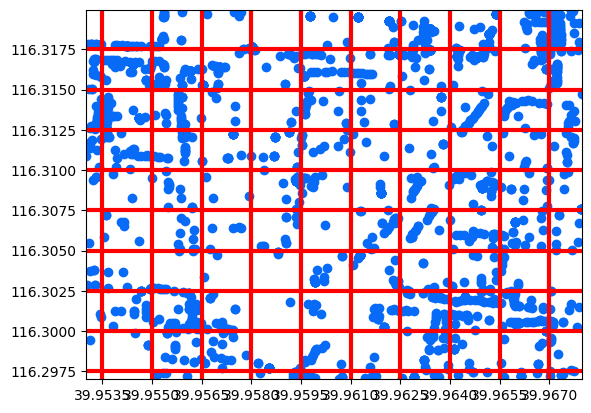

In [2053]:
# Adding all points to the plot
x = [ind.latitude for ind in index.poi_list]
y = [ind.longitude for ind in index.poi_list]
plt.scatter(x, y, color="#076bf8")
# Setting boarders
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(index.boarders))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(index.boarders))
plt.grid(color="r", linewidth=3)

# Set start and end points for x and y axes
plt.xlim(index.min_latitude, index.max_latitude)
plt.ylim(index.min_longitude, index.max_longitude) 

Grid-based Spatial Indexing
1. Partition the space into disjoint and uniform grids
2. Build inverted index between each grid and the points in the grid

ATM type and query point

In [2054]:
type_regex_str = "1603"
query_point = Point(39.958, 116.311)

### Searching for the nearest ATM with spatial indexing

In [2055]:
res = index.nearest_neighbor_query(query_point, type_regex_str)
print("Nearest ATM around Central Building of BIT (spatial indexing):")
print(f"ID: {res.id}, Latitude: {res.latitude}, Longitude: {res.longitude}, Type Code: {res.type_code}")

Nearest ATM around Central Building of BIT (spatial indexing):
ID: 1120, Latitude: 39.9565121976451, Longitude: 116.31054154116, Type Code: 160306


### Searching for the nearest ATM with brute force

In [2056]:
res = index.nearest_neighbor_scan(query_point, type_regex_str)
print("Nearest ATM around Central Building of BIT (brute-force):")
print(f"ID: {res.id}, Latitude: {res.latitude}, Longitude: {res.longitude}, Type Code: {res.type_code}")

Nearest ATM around Central Building of BIT (brute-force):
ID: 1120, Latitude: 39.9565121976451, Longitude: 116.31054154116, Type Code: 160306


The algorithms found the same ATM with the same ID, which means that both algorithms work correctly

### Representing the nearest ATM on the map

Create a street network graph within the specified bounding box

In [2057]:
G = ox.graph_from_bbox(bbox=(index.min_latitude, index.max_latitude, index.min_longitude, index.max_longitude))

Latitude and longitude of the new point is latitude and longitude of the result

Add the new point as a node to the graph and connect it to the nearest node

In [2058]:
G.add_node("ATM", x=res.longitude, y=res.latitude)

Adding starting point

In [2059]:
G.add_node("ME", x=query_point.longitude, y=query_point.latitude)

Adding all ATM's

In [2060]:
i = 0
for poi in index.poi_list:
    if poi.type_code.startswith(type_regex_str):
        # Adding the nearest ATM only one time
        if not (G.nodes["ATM"]["x"] == poi.longitude and G.nodes["ATM"]["y"] == poi.latitude):
            # Making new ids
            i += 1
            G.add_node(i, x=poi.longitude, y=poi.latitude)

Coloring points

In [2061]:
node_color = []
for n in G.nodes():
    if n == "ATM":
        node_color.append("#DA3E52")
    elif n == "ME":
        node_color.append("#12ed65")
    elif 1 <= n <= 1000000:
        node_color.append("#076bf8")
    else:
        node_color.append("none")

Plot the updated graph with the new point

(blue - all ATMs, red - the nearest ATM, green - start)

Text(0.5, 1.0, 'Nearest ATM around Central Building of BIT')

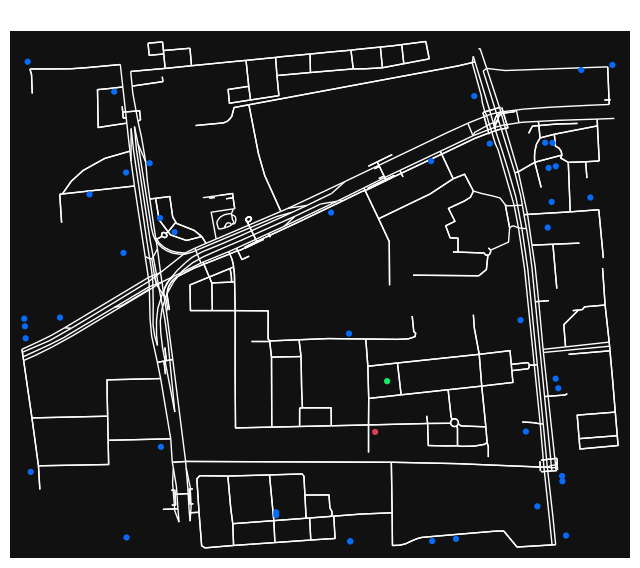

In [2062]:
fig, ax = ox.plot_graph(G, node_color=node_color, node_size=20, edge_color="w", show=False, close=False)
ax.set_title("Nearest ATM around Central Building of BIT", color="white")

Query point and range and type of the point

In [2063]:
query_point = Point(39.955, 116.310)
# If I understood correctly, the radius is 500 meters. This means that I need a square with a side of 1000 meters.
query_range = Rectangle(query_point, 1000)
type_regex_str = "5"

### Searching for the restaurants in 1000x1000 meters square near the south door of BIT with brute force 

In [2064]:
res = index.range_scan(query_range, type_regex_str)
print("Nearest restaurants to the south door of BIT:")
count_of_restaurants = len(res)
print(f"Count of restaurants in 1000x1000 meters square: {count_of_restaurants}")
for poi in res:
    print(f"ID: {poi.id}, Latitude: {poi.latitude}, Longitude: {poi.longitude}, Type Code: {poi.type_code}")

Nearest restaurants to the south door of BIT:
Count of restaurants in 1000x1000 meters square: 46
ID: 8, Latitude: 39.954419455158, Longitude: 116.310981826996, Type Code: 50500
ID: 18, Latitude: 39.9536679852345, Longitude: 116.313367582772, Type Code: 50000
ID: 27, Latitude: 39.9557845901446, Longitude: 116.314058757593, Type Code: 50115
ID: 28, Latitude: 39.9576987562609, Longitude: 116.306435378175, Type Code: 50500
ID: 33, Latitude: 39.9537194425661, Longitude: 116.31206649601, Type Code: 50100
ID: 41, Latitude: 39.9560135808697, Longitude: 116.311413664664, Type Code: 50400
ID: 52, Latitude: 39.9593645344109, Longitude: 116.307065805796, Type Code: 50100
ID: 62, Latitude: 39.9545775874651, Longitude: 116.310907971271, Type Code: 50100
ID: 63, Latitude: 39.9538459366335, Longitude: 116.313389510973, Type Code: 50100
ID: 65, Latitude: 39.9536057693156, Longitude: 116.312425706112, Type Code: 50100
ID: 67, Latitude: 39.9531347054657, Longitude: 116.31140803998, Type Code: 50000
ID: 

### Searching for the restaurants in 1000x1000 meters square near the south door of BIT with spatial indexing 

In [2065]:
res = index.range_query(query_range, type_regex_str)
print("Nearest restaurants to the south door of BIT:")
count_of_restaurants = len(res)
print(f"Count of restaurants in 1000x1000 meters square: {count_of_restaurants}")
for poi in res:
    print(f"ID: {poi.id}, Latitude: {poi.latitude}, Longitude: {poi.longitude}, Type Code: {poi.type_code}")

Nearest restaurants to the south door of BIT:
Count of restaurants in 1000x1000 meters square: 46
ID: 131, Latitude: 39.9558212295247, Longitude: 116.305118438809, Type Code: 50500
ID: 130, Latitude: 39.9558777303887, Longitude: 116.307034312937, Type Code: 50100
ID: 132, Latitude: 39.9559910245181, Longitude: 116.306871650817, Type Code: 50100
ID: 28, Latitude: 39.9576987562609, Longitude: 116.306435378175, Type Code: 50500
ID: 52, Latitude: 39.9593645344109, Longitude: 116.307065805796, Type Code: 50100
ID: 185, Latitude: 39.9593475416916, Longitude: 116.307605635839, Type Code: 50100
ID: 186, Latitude: 39.9594297281297, Longitude: 116.308044668814, Type Code: 50100
ID: 230, Latitude: 39.9593803209729, Longitude: 116.306636732014, Type Code: 50100
ID: 135, Latitude: 39.9532334862187, Longitude: 116.309385509306, Type Code: 50100
ID: 136, Latitude: 39.9539428800236, Longitude: 116.310765368082, Type Code: 50121
ID: 257, Latitude: 39.9539129496867, Longitude: 116.310194637276, Type Cod

The algorithms found the same restaurants with the same IDs, which means that both algorithms work correctly

### Representing restaurants in query box

Create a street network graph within the specified bounding box (new one)

In [2066]:
G = ox.graph_from_bbox(bbox=(index.min_latitude, index.max_latitude, index.min_longitude, index.max_longitude))

Adding all restaurants

In [2067]:
i = 0
for poi in res:
    i += 1
    G.add_node(i, x=poi.longitude, y=poi.latitude)

Adding restaurants that we found to the graph

In [2068]:
i = count_of_restaurants
for poi in index.poi_list:
    if poi.type_code.startswith(type_regex_str):
        for j in range(1, count_of_restaurants + 1):
            if G.nodes[j]["x"] == poi.longitude and G.nodes[j]["y"] == poi.latitude:
                break
        else:
            # Making new ids
            i += 1
            G.add_node(i, x=poi.longitude, y=poi.latitude)

Creating nodes and edges for the starting query box

In [2069]:
G.add_node(999, x=query_range.upper_left.longitude, y=query_range.upper_left.latitude)
G.add_node(1000, x=query_range.upper_left.longitude, y=query_range.bottom_right.latitude)
G.add_node(1001, x=query_range.bottom_right.longitude, y=query_range.bottom_right.latitude)
G.add_node(1002, x=query_range.bottom_right.longitude, y=query_range.upper_left.latitude)

Creating edges from nodes ids (we will identify edges by pair: node-node)

In [2070]:
G.add_edge(999, 1000)
G.add_edge(1000, 1001)
G.add_edge(1001, 1002)
G.add_edge(1002, 999)

0

Adding the query point (south door of BIT)

In [2071]:
G.add_node(5000, x=query_point.longitude, y=query_point.latitude)

Coloring nodes

In [2072]:
node_color = []
for n in G.nodes():
    if 1 <= n <= count_of_restaurants:
        node_color.append("#DA3E52")
    elif 999 <= n <= 1002:
        # Decided not to show points for the starting box
        node_color.append("none")
    elif n == 5000:
        node_color.append("#12ed65")
    elif count_of_restaurants < n < 1000000:
        node_color.append("#076bf8")
    else:
        node_color.append("none")

Coloring edges

In [2073]:
edge_color = []
for e in G.edges():
    if (e == (999, 1000)
            or e == (1000, 1001)
            or e == (1001, 1002)
            or e == (1002, 999)):
        edge_color.append("#12ed65")
    else:
        edge_color.append("w")

(blue - all restaurants, red - restaurants in query box, green - start box)

Text(0.5, 1.0, 'The restaurants in 1000x1000 meters square')

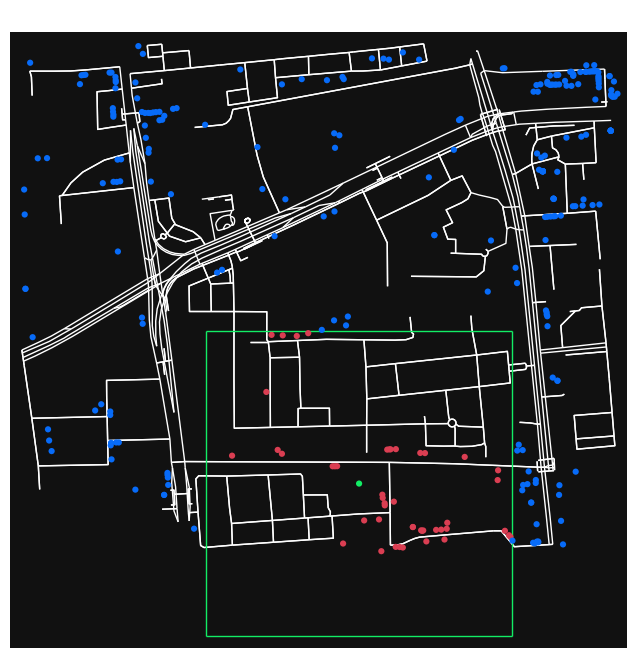

In [2074]:
fig, ax = ox.plot_graph(G, node_color=node_color, node_size=20, show=False, close=False, edge_color=edge_color)
ax.set_title("The restaurants in 1000x1000 meters square", color="white")

## Measuring execution time

The cpu time is the amount of time spent in user code and the amount of time spent in kernel code

Wall-clock time is the time that a clock on the wall would measure as having elapsed between the start of the process and 'now'

### Brute Force

In [2075]:
%%time
for _ in range(1000): index.nearest_neighbor_scan(query_point, type_regex_str)

CPU times: total: 109 ms
Wall time: 316 ms


In [2076]:
%%time
for _ in range(1000): index.range_scan(query_range, type_regex_str)

CPU times: total: 0 ns
Wall time: 202 ms


### Spatial index

In [2077]:
%%time
for _ in range(1000): index.nearest_neighbor_query(query_point, type_regex_str)

CPU times: total: 0 ns
Wall time: 6.54 ms


In [2078]:
%%time
for _ in range(1000): index.range_query(query_range, type_regex_str)

CPU times: total: 0 ns
Wall time: 84.3 ms


Results show us that algorithms bases on the spatial indexing faster than based on the brute force indexing